In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tf

**Set up environment**

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


**Detect TPU**

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


**Set up variables**

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25

**Load the data**
**Decode the data**

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [6]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

**A note on using train_test_split()**

In [8]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.35, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

**Adding in augmentations**

In [9]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label

Define data loading methods

In [10]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [11]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 13380 training images, 8017 validation images, 1 (unlabeled) test images


Brief exploratory data analysis (EDA)

In [15]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [3 3 2 3 1 3 4 1 2 3 1 3 3 3 4 0 4 3 3 1 3 3 4 3 3 4 2 3 2 1 3 3 3 3 3 3 3
 2 3 1 3 3 4 0 3 3 3 4 2 3 3 3 3 3 1 2 3 2 3 4 1 3 3 3 3 3 1 1 3 3 4 1 4 3
 3 3 3 3 2 3 3 3 0 3 3 3 2 3 3 3 3 2 0 0 3 1 3 3 3 3 1 3 4 3 4 3 3 4 3 1 3
 4 3 3 3 3 4 3 2 3 3 3 2 3 3 3 3 3]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [3 3 3 3 3 2 1 3 3 4 3 3 3 3 0 3 1 3 2 3 1 1 3 1 3 3 3 4 3 1 3 1 3 3 3 3 3
 3 3 3 1 3 3 3 3 0 3 3 3 3 4 3 2 3 3 3 3 2 2 3 2 3 1 2 3 2 4 3 4 3 4 3 3 3
 4 3 3 4 3 3 4 3 3 4 0 4 2 3 4 3 3 1 3 2 3 3 2 3 3 3 3 3 3 3 1 2 3 3 4 3 1
 3 0 2 4 0 3 3 3 3 4 4 2 4 3 3 3 3]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


In [16]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [17]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

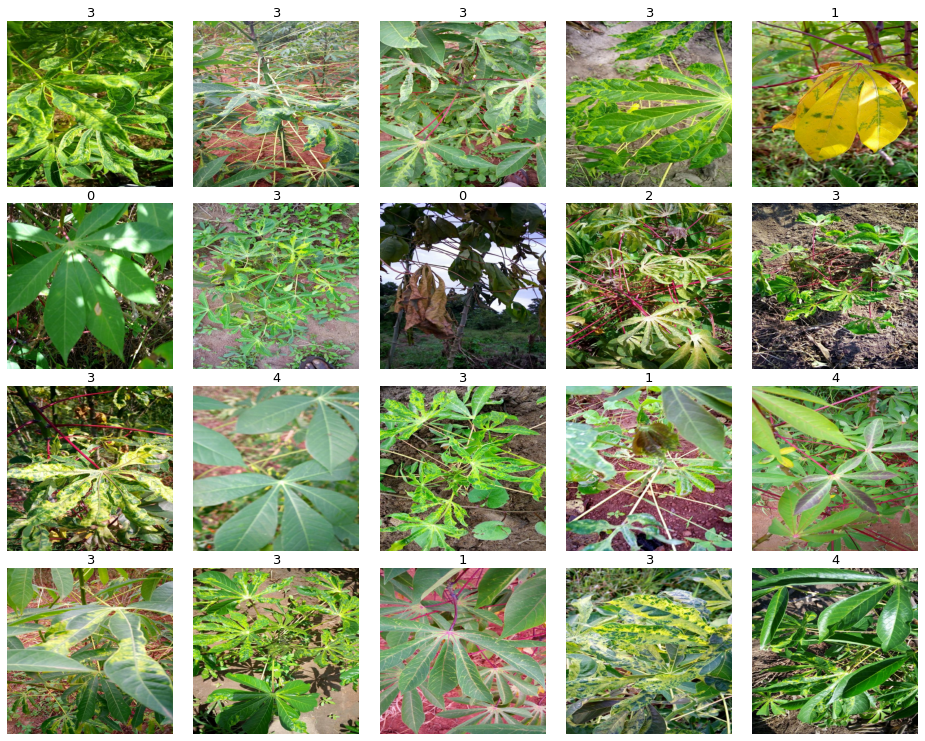

In [18]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

In [19]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

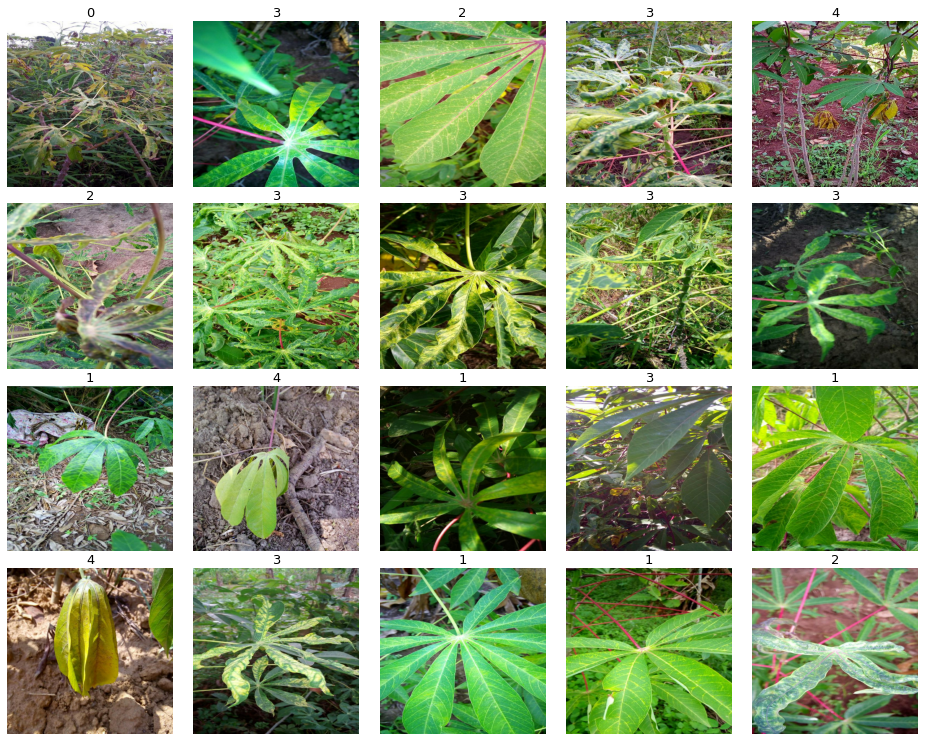

In [20]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(valid_batch))

In [21]:
# load our test dataset for EDA
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

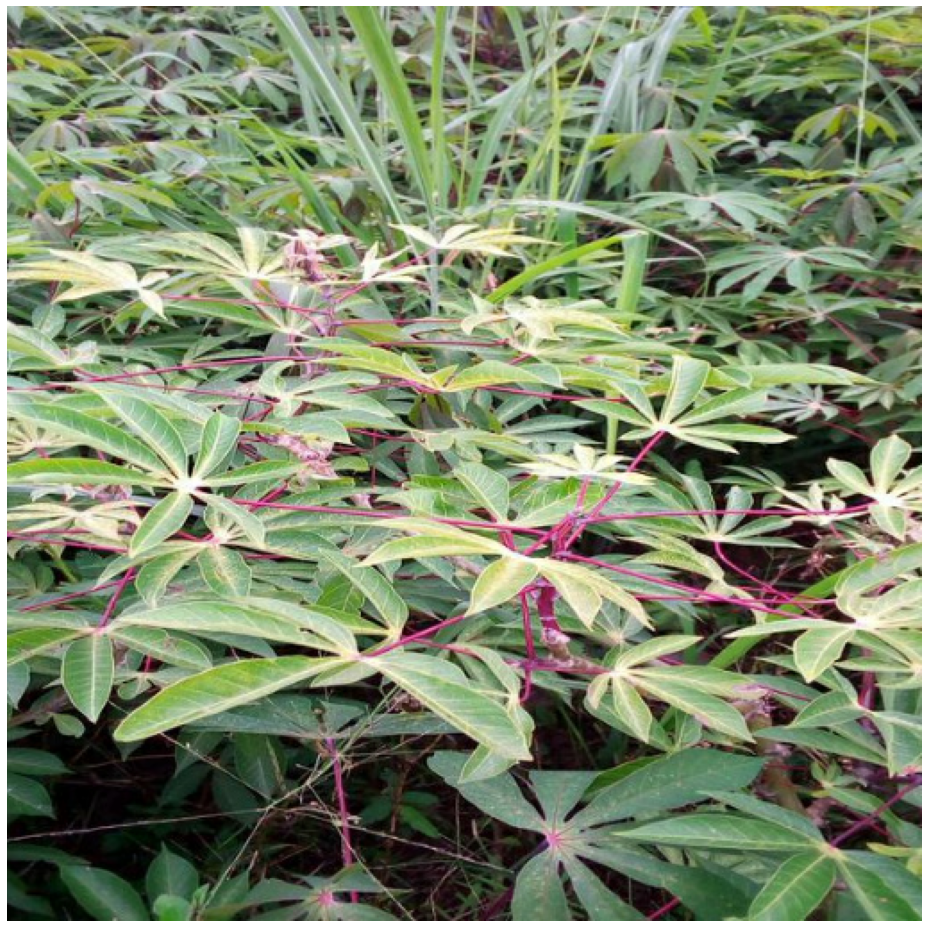

In [22]:
# we only have one test image
display_batch_of_images(next(test_batch))

Building the model

Learning rate schedule

In [23]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

Building our model

In [24]:
with strategy.scope():       
    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        #tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])

94773248/94765736 [==============================] - 1s 0us/step


Train the model

In [25]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [26]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS)

Epoch 1/25
104/104 [==============================] - 69s 502ms/step - loss: 2.2668 - sparse_categorical_accuracy: 0.1094 - val_loss: 2.1162 - val_sparse_categorical_accuracy: 0.1155
Epoch 2/25
104/104 [==============================] - 42s 404ms/step - loss: 2.0569 - sparse_categorical_accuracy: 0.1086 - val_loss: 1.7680 - val_sparse_categorical_accuracy: 0.1119
Epoch 3/25
104/104 [==============================] - 43s 417ms/step - loss: 1.6877 - sparse_categorical_accuracy: 0.1533 - val_loss: 1.4739 - val_sparse_categorical_accuracy: 0.4417
Epoch 4/25
104/104 [==============================] - 43s 411ms/step - loss: 1.4400 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.3789 - val_sparse_categorical_accuracy: 0.5796
Epoch 5/25
104/104 [==============================] - 42s 402ms/step - loss: 1.3671 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.3294 - val_sparse_categorical_accuracy: 0.5993
Epoch 6/25
104/104 [==============================] - 42s 406ms/step - loss: 1.3205 -

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 512, 512, 3)       21        
_________________________________________________________________
lambda (Lambda)              (None, 512, 512, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 23,604,170
Trainable params: 16,443
Non-trainable params: 23,587,727
_______________________________________

Evaluating our model

In [28]:
# print out variables available to us
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


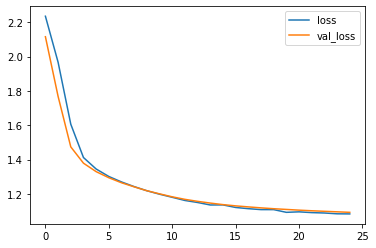

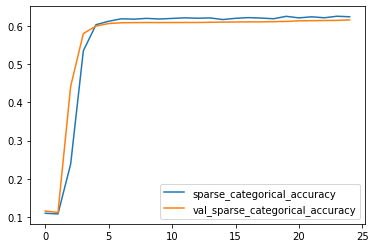

In [29]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

Making predictions

In [30]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [31]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
test_images_ds = testing_dataset
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[3]


Creating a submission file

In [32]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Generating submission.csv file...
id,label
2216849948.jpg,3
